# Projet détection des races de chiens

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
from glob import glob
 
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
 
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow

from pathlib import Path

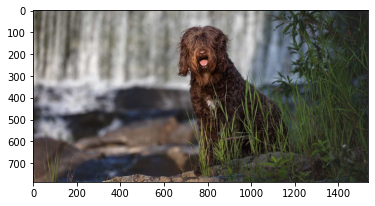

In [ ]:
image = imread("/content/drive/MyDrive/Formation IA/Deep Learning/Patrick Wampé /chiens/train/Barbet/img (10).jpg")
plt.imshow(image)

In [ ]:
image.shape

(786, 1536, 3)

In [ ]:
src_path_train = "/content/drive/MyDrive/Formation IA/Deep Learning/Patrick Wampé /chiens/train"
src_path_test = "/content/drive/MyDrive/Formation IA/Deep Learning/Patrick Wampé /chiens/test"

IMSIZE = [128, 128]
batch_size = 14
 
image_gen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)
 
# create generators
train_generator = image_gen.flow_from_directory(
  src_path_train,
  target_size=IMSIZE,
  shuffle=True,
  batch_size=batch_size,
)
 
test_generator = image_gen.flow_from_directory(
  src_path_test,
  target_size=IMSIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 61 images belonging to 4 classes.
Found 27 images belonging to 4 classes.


In [ ]:
NBCLASSES = 4
train_image_files = glob(src_path_train + '/*/*.jp*g')
test_image_files = glob(src_path_test + '/*/*.jp*g')
 
def create_model():
    vgg = VGG16(input_shape=(IMSIZE+ [3]), weights='imagenet', include_top=False)
 
    # Freeze existing VGG already trained weights
    for layer in vgg.layers:
        layer.trainable = False
     
    # get the VGG output
    out = vgg.output
     
    # Add new dense layer at the end
    x = Flatten()(out)
    x = Dense(NBCLASSES, activation='softmax')(x)
     
    model = Model(inputs=vgg.input, outputs=x)
     
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])
     
    model.summary()
     
    return model
 
mymodel = create_model()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
epochs = 30
early_stop = EarlyStopping(monitor= 'val_accuracy', patience=4 , mode = 'max', restore_best_weights=False)
 
mymodel.fit(
  train_generator,
  validation_data=test_generator,
  epochs=epochs,
  steps_per_epoch=len(train_image_files) // batch_size,
  validation_steps=len(test_image_files) // batch_size,
  callbacks=[early_stop]
)

Epoch 1/30
4/4 [==============================] - 12s 3s/step - loss: 0.2119 - accuracy: 0.9787 - val_loss: 0.7893 - val_accuracy: 0.7143
Epoch 2/30
4/4 [==============================] - 11s 3s/step - loss: 0.1442 - accuracy: 1.0000 - val_loss: 0.8463 - val_accuracy: 0.7143
Epoch 3/30
4/4 [==============================] - 11s 3s/step - loss: 0.1477 - accuracy: 0.9787 - val_loss: 1.1851 - val_accuracy: 0.5000
Epoch 4/30
4/4 [==============================] - 11s 3s/step - loss: 0.1447 - accuracy: 0.9787 - val_loss: 0.6427 - val_accuracy: 0.7857
Epoch 5/30
4/4 [==============================] - 11s 3s/step - loss: 0.1694 - accuracy: 1.0000 - val_loss: 0.7883 - val_accuracy: 0.7143
Epoch 6/30
4/4 [==============================] - 13s 3s/step - loss: 0.1278 - accuracy: 1.0000 - val_loss: 0.6067 - val_accuracy: 0.7857
Epoch 7/30
4/4 [==============================] - 11s 3s/step - loss: 0.1422 - accuracy: 0.9787 - val_loss: 1.0064 - val_accuracy: 0.5714
Epoch 8/30
4/4 [==================

In [ ]:
score = mymodel.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 5s 3s/step - loss: 0.8409 - accuracy: 0.6296
Test loss: 0.8409494757652283
Test accuracy: 0.6296296119689941


In [ ]:
json_model = mymodel.to_json()
model_file = Path("/content/drive/MyDrive/Formation IA/Deep Learning/Patrick Wampé /chiens/json_model.json")
model_file.write_text(json_model)
mymodel.save_weights("/content/drive/MyDrive/Formation IA/Deep Learning/Patrick Wampé /chiens/weights.h5")

In [ ]:
mymodel.save('/content/drive/MyDrive/Formation IA/Deep Learning/Patrick Wampé /chiens/model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation IA/Deep Learning/Patrick Wampé /chiens/model/assets


In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

NameError: ignored

## Fait à la main

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(224, 224, 3)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),        
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)), 
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),        
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)), 
        layers.Flatten(),
        layers.Dense(32, activation="softmax"),
        layers.Dense(12, activation="softmax")
    ]
)

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics = ['accuracy'])

model.summary()

In [ ]:
Barbet_dossier_test = Path("/content/drive/MyDrive/Formation IA/Deep Learning/Patrick Wampé /chiens/test/Barbet")
males_dossier_test = Path("/content/drive/MyDrive/Formation IA/Deep Learning/Patrick Wampé /chiens/test/Dogue_de_Bordeaux")
males_dossier_test = Path("/content/drive/MyDrive/Formation IA/Deep Learning/Patrick Wampé /chiens/test/beauceron")
males_dossier_test = Path("/content/drive/MyDrive/Formation IA/Deep Learning/Patrick Wampé /chiens/test/lowchen")

In [ ]:
# TEST DATAS

test_images = []
test_target = []

height = 128
width = 128

# Ettiquette 0 pour male
for current_file in males_dossier_test.glob("*.JPG"):
    current_img = image.load_img(current_file, target_size=(height,width))
    current_img = image.img_to_array(current_img)  
    test_images.append(current_img)
    test_target.append(0)

# Ettiquette 1 pour femelle
for current_file in femeles_dossier_test.glob("*.JPG"):
    current_img = image.load_img(current_file, target_size=(height,width))
    current_img = image.img_to_array(current_img)  
    test_images.append(current_img)
    test_target.append(1)

# Ettiquette 1 pour femelle
for current_file in femeles_dossier_test.glob("*.JPG"):
    current_img = image.load_img(current_file, target_size=(height,width))
    current_img = image.img_to_array(current_img)  
    test_images.append(current_img)
    test_target.append(1)

# Ettiquette 1 pour femelle
for current_file in femeles_dossier_test.glob("*.JPG"):
    current_img = image.load_img(current_file, target_size=(height,width))
    current_img = image.img_to_array(current_img)  
    test_images.append(current_img)
    test_target.append(1)